# ParTIpy Analysis of on non-classical Monocytes from Lupus Data 

TODO
- add/fix t-ratio function
- Function mean archetype variance for different n_archetypes

In [59]:
import scanpy as sc
import seaborn as sns
from ParTIpy.paretoti_funcs import *
from ParTIpy.arch import AA
from ParTIpy.enrichment import *
import decoupler as dc

## Introduction

Cells of the same type often exhibit a continuum of gene expression states, reflecting their functional diversity and adaptability. The Pareto task optimality theory provides a framework to interpret this variability by organizing cells within a low-dimensional polytope in gene expression space. The vertices of this polytope represent specialized "archetypes"—cells optimized for specific tasks performed by the cell type.

Given this theoretical foundation, archetypal analysis is most meaningful when applied to a single cell type. In this vignette, we focus specifically on **non-classical monocytes** to explore their gene expression patterns and uncover the underlying task specialization from their transcriptional profiles. As algorithm for the archetypal analysis we will use PCHA with random initialization.

## Load Data


In [60]:
adata = sc.read_h5ad("/gpfs/lsdf02/sd22b002/guest/ParTIpy/Data/Lupus.h5ad")

In [61]:
adata_ncM = adata[adata.obs["cg_cov"] == 'ncM', :].copy()
adata_ncM

AnnData object with n_obs × n_vars = 38106 × 25275
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'sample_id', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'n_genes'
    var: 'ensembl', 'feature_types', 'n_cells'

## Quality Control

We follow the Scanpy [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html) to perform quality control on our dataset
We first compute the proportion of counts originating from mitochondrial, ribosomal, and hemoglobin genes:

In [62]:
adata_ncM.var["mt"] = adata_ncM.var_names.str.startswith("MT-")
adata_ncM.var["ribo"] = adata_ncM.var_names.str.startswith(("RPS", "RPL"))
adata_ncM.var["hb"] = adata_ncM.var_names.str.contains(("^HB[^(P)]"))

In [63]:
sc.pp.calculate_qc_metrics(
    adata_ncM, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

We can now examine key quality control metrics, including:
- The number of genes expressed per cell
- The total counts per cell
- The percentage of counts originating from mitochondrial genes

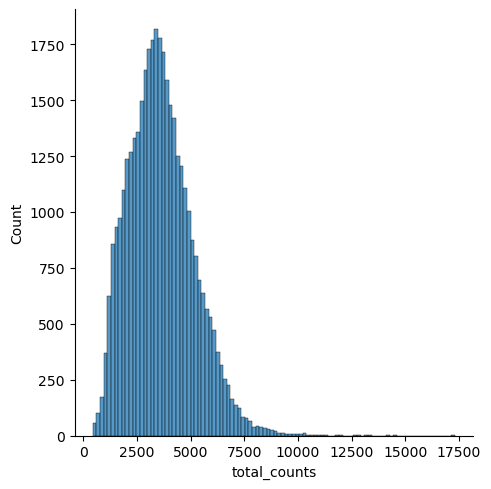

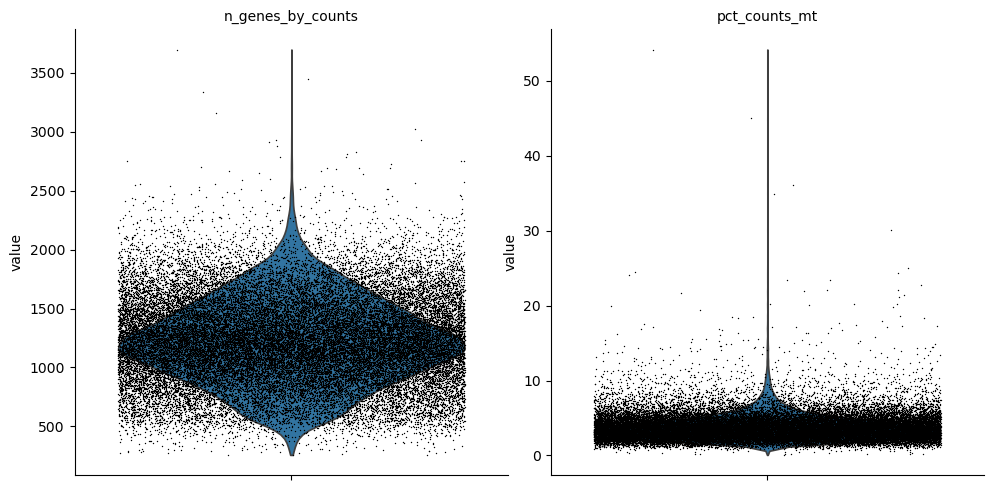

In [64]:
p1 = sns.displot(adata_ncM.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(
    adata_ncM,
    ["n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

To remove low-quality data, we filter out cells with fewer than 100 detected genes and genes that are present in fewer than 3 cells. This ensures that only high-quality cells and genes are retained for downstream analysis.

In [65]:
print(f"Number of cells before filtering: {adata_ncM.n_obs} \nNumber of genes before filtering: {adata_ncM.n_vars}")
sc.pp.filter_cells(adata_ncM, min_genes=100)
sc.pp.filter_genes(adata_ncM, min_cells=3)
print(f"Number of cells after filtering of low quality cells: {adata_ncM.n_obs} \nNumber of genes after filtering of low quality genes: {adata_ncM.n_vars}")

Number of cells before filtering: 38106 
Number of genes before filtering: 25275
Number of cells after filtering of low quality cells: 38106 
Number of genes after filtering of low quality genes: 18787


## Normalization and feature selection

To ensure comparability across cells, we normalize the data to the median total counts per cell and apply a logarithmic transformation:

In [66]:
sc.pp.normalize_total(adata_ncM)
sc.pp.log1p(adata_ncM)

ANext, we identify highly variable genes, which are key for downstream analysis. We also visualize them to assess their distribution:

In [67]:
sc.pp.highly_variable_genes(adata_ncM)

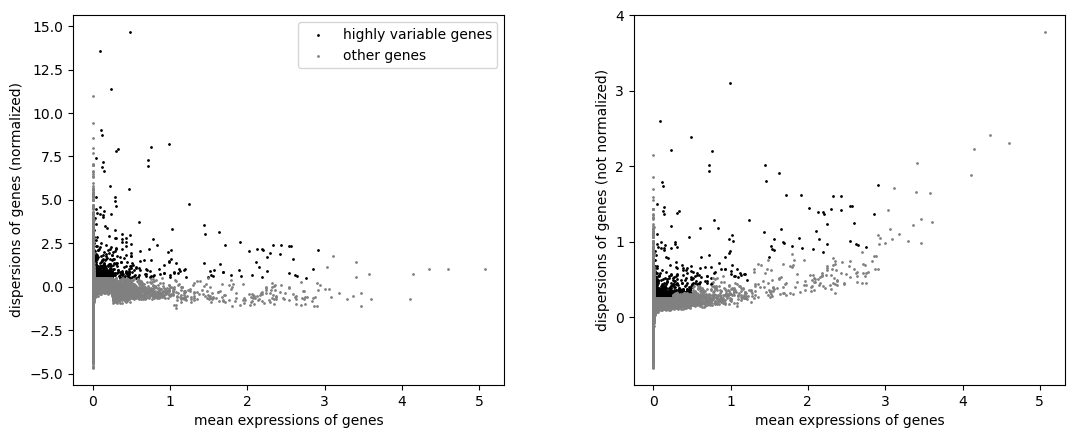

In [68]:
sc.pl.highly_variable_genes(adata_ncM)

For downstream enrichment analysis, we standardize the data by scaling gene expression values:

In [69]:
adata_ncM.layers["z_scaled"]= sc.pp.scale(adata_ncM.X, max_value=10)

## Dimension Reduction

We compute Principal Component Analysis (PCA) using only highly variable genes and visualize the results:

In [70]:
sc.pp.pca(adata_ncM, mask_var="highly_variable")

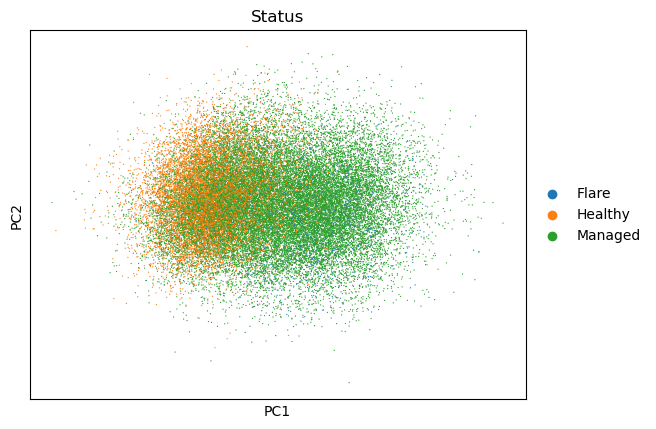

In [71]:
sc.pl.pca_scatter(adata_ncM, color="Status")

# For coloring after batch use:
# color="Processing_Cohort"

To determine the optimal number of principal components (PCs) to retain, we inspect their contribution to the total variance:

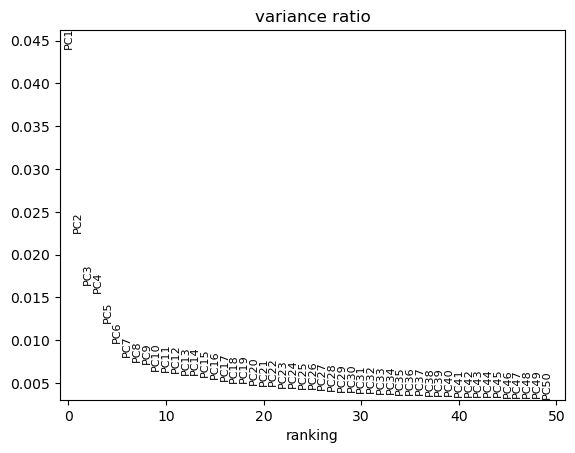

In [72]:
sc.pl.pca_variance_ratio(adata_ncM, n_pcs=50)

Based on this, we select 7 PCs, as the variance explained plateaus beyond this point.

In [73]:
n_pcs = 7

For ease of use in downstream analysis, we store the PCA results with only the first 7 components in adata_ncM.obsm["X_pca_reduced"]:

In [74]:
# Data we will use for further analysis
reduce_pca(adata=adata_ncM, n_pcs=n_pcs)

## Number of Archetypes

Next, we need to determine the optimal number of archetypes in our data—essentially, the number of vertices in the polyhedron.

We first assess how much variance is explained for different numbers of archetypes.

The function var_explained_aa() takes the reduced PCA data and calculates the explained variance for a range of archetypes (min_a to max_a). Additionally, it computes:

- The variance explained by each archetype.
- The additional variance explained by each successive archetype.
- The distance from the projected point to the line of the elbow plot.

In [75]:
var_explained_aa(adata=adata_ncM, min_a=2, max_a=10)

The results are stored in:

In [76]:
adata_ncM.uns["AA_var"]

k   varexpl  varexpl_ontop  dist_to_projected
0   2  0.342221       0.342221           0.000000
1   3  0.509094       0.166873           0.096583
2   4  0.621943       0.112849           0.139274
3   5  0.712190       0.090247           0.159418
4   6  0.772446       0.060255           0.149644
5   7  0.825167       0.052721           0.132354
6   8  0.860633       0.035466           0.097852
7   9  0.890954       0.030321           0.058217
8  10  0.902648       0.011694           0.000000

We visualize the explained variance for different models:

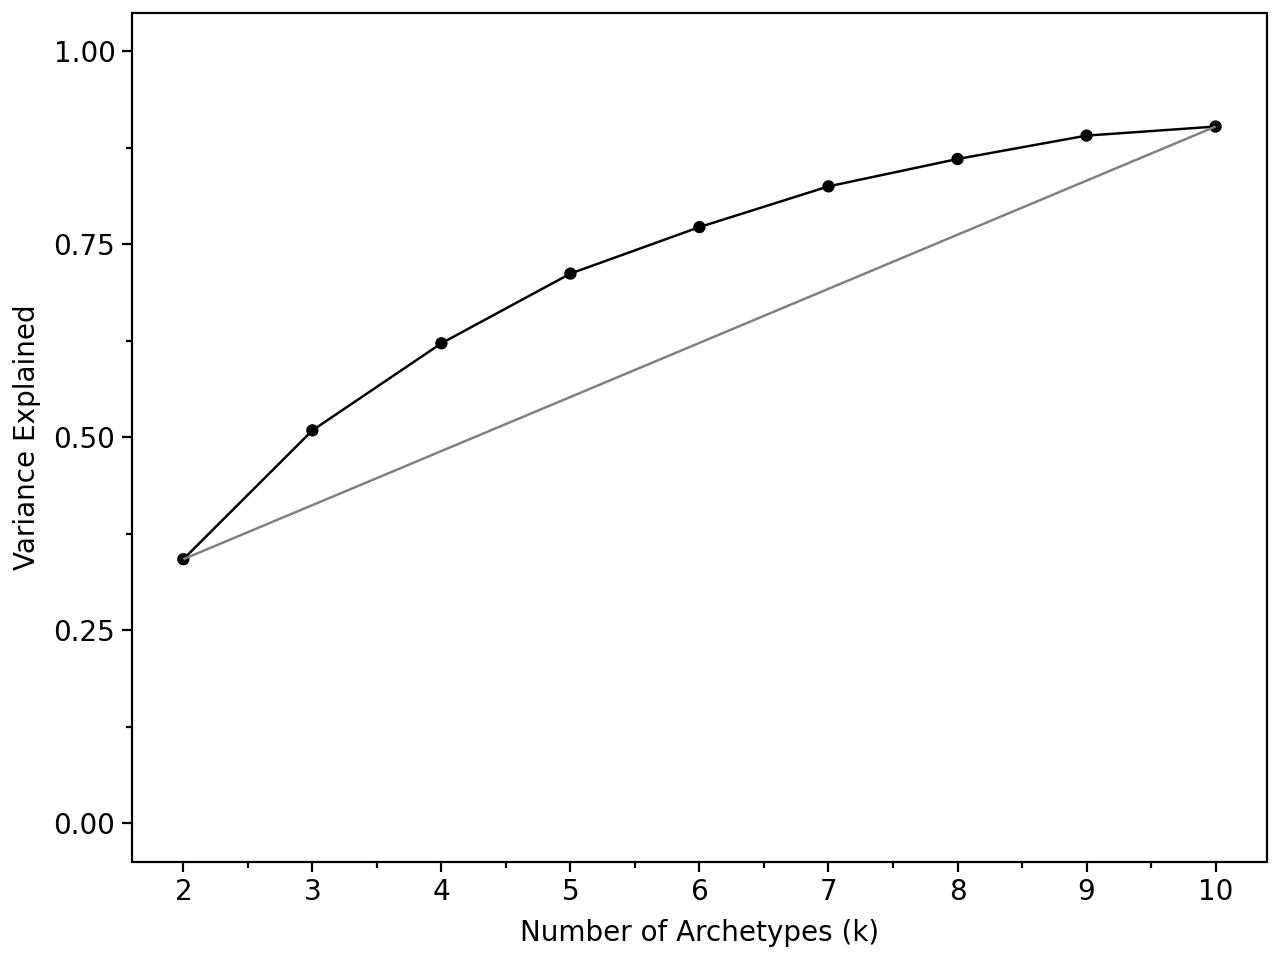

In [77]:
plot_var_explained_aa(adata_ncM)

In this plot, the grey line connects the first and last variance explained (EV) values, helping to identify the "elbow" of the black curve.

Since the axes are not equally scaled, the projection from the furthest point of the black line onto the grey line may not appear orthogonal. To better visualize the distances, we use:

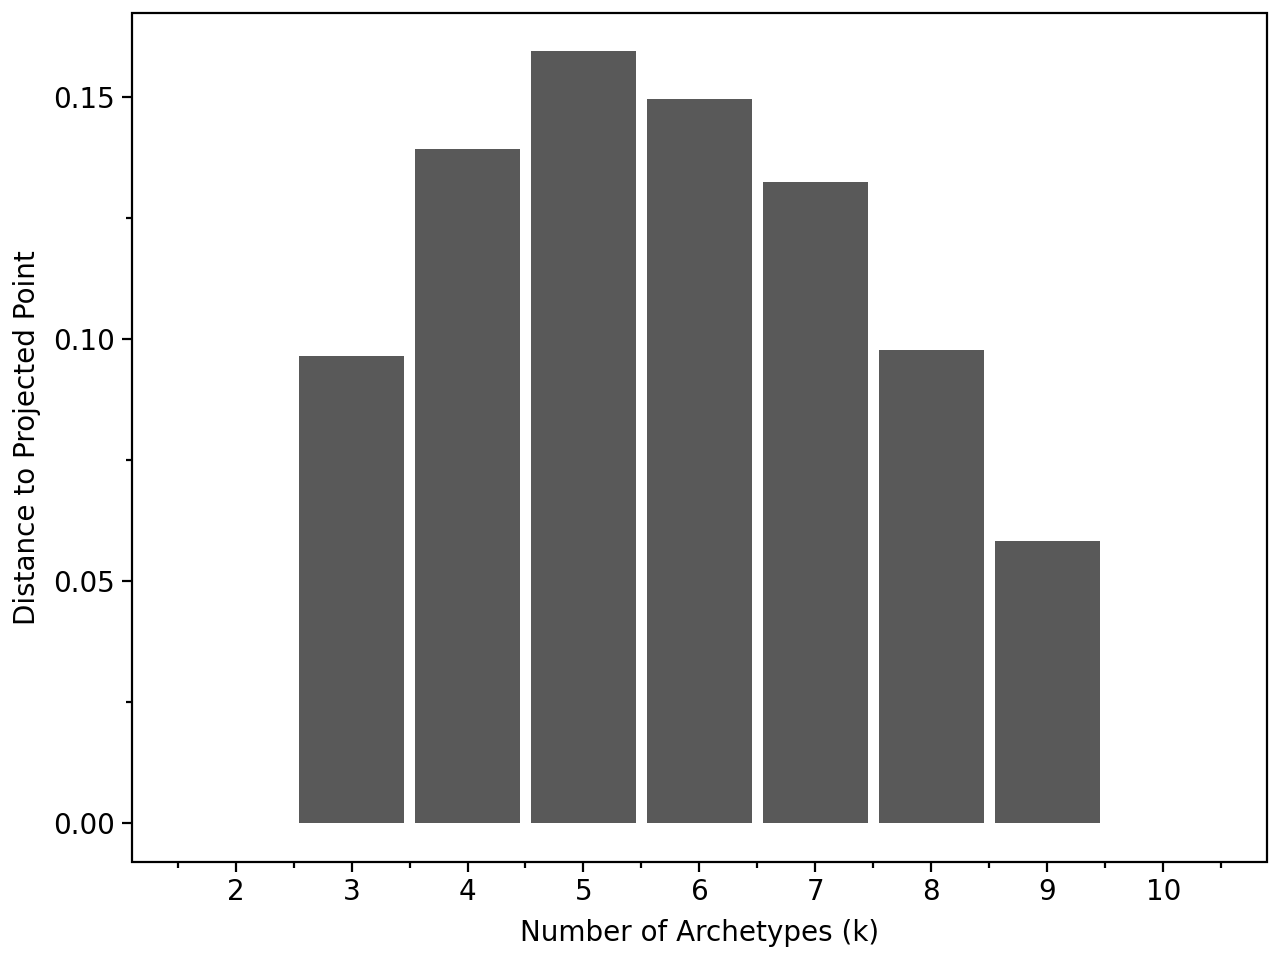

In [78]:
plot_projected_dist(adata_ncM)

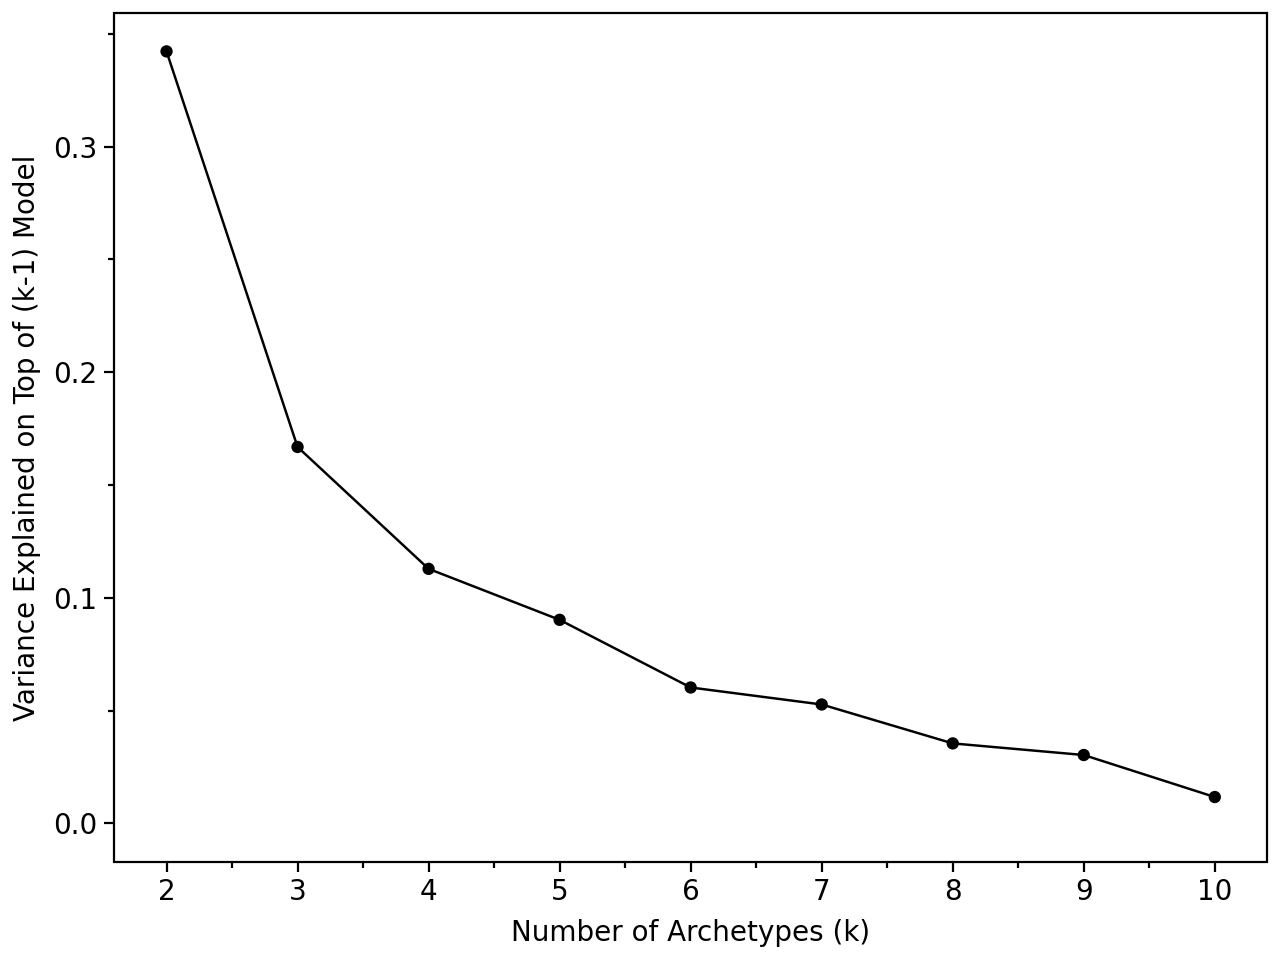

In [79]:
plot_var_on_top(adata_ncM)

This analysis suggests that the best choice is 5 archetypes. However, after further validation, we decide to use 4 archetypes, as later analyses show that the 5th archetype introduces no new tasks.

In [80]:
n_archetypes = 4

To validate the archetype stability, we apply bootstrapping. We sample the data five times (for efficiency) and run Archetypal Analysis (AA) on each sample. 

In [81]:
bootstrap_aa(adata=adata_ncM, n_bootstrap=5, n_archetypes=n_archetypes)

The positions of the archetypes and the mean variance across all bootstrapped samples are stored in:

In [82]:
adata_ncM.uns["AA_bootstrap"]

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0  1.777950  4.420336 -2.378698 -1.352312  0.564991  0.039494 -0.300667   
1  6.188856 -1.973357  0.770540  0.522010 -0.308187 -0.060260  0.117843   
2 -5.396343  2.306962  4.080320  3.555760 -0.861210 -0.760243  0.236313   
3 -3.307060 -3.433427 -1.226042 -1.408888  0.287431  0.345949 -0.045978   
0  2.705293  3.902787  1.399287 -2.874889  0.839279  0.020072 -0.064446   
1  6.091582 -3.046217 -0.717160  1.391914 -0.241936 -0.078934  0.167796   
2 -3.373141  2.633553 -1.292300  3.775837 -1.125619  0.039035  0.090465   
3 -3.831116 -2.622338  0.364536 -1.489749  0.301705 -0.110488 -0.151816   
0  1.566308  4.857223 -2.476038 -1.568320  0.704721 -0.194168 -0.394649   
1  6.228191 -2.556815  0.673258  0.506486 -0.510648  0.017513  0.045754   
2 -3.135713  2.016284  3.662485  2.248084 -0.418426 -0.420508  0.239524   
3 -3.691374 -3.122113 -1.346575 -0.825689  0.148085  0.281177  0.033195   
0  1.079516  4.798435 -2.301392 -1.420548  0.482819  0.046398 -0.723236   
1  5.923921 -2.006884  0.556544  0.589139 -0.242688 -0.151067  0.408696   
2 -3.055392  1.889345  3.691830  2.368088 -0.392080 -0.269256  0.319733   
3 -3.790656 -3.334570 -1.395445 -1.133009  0.124466  0.121928 -0.103144   
0 -0.048920  3.449173 -3.842995  1.039628  0.438244  0.082285 -0.108230   
1  6.429809 -2.615600  0.008768  0.477185 -0.473351 -0.094343  0.111308   
2 -0.604828  4.002777  3.688846 -1.627585  0.133195 -0.181481  0.349503   
3 -4.295491 -2.924706  0.157777  0.038725 -0.023763 -0.035375 -0.264901   
0  2.086570  4.651742 -2.560881 -1.503578  0.558446 -0.210629 -0.293798   
1  6.104597 -2.342802  1.028187  0.609359 -0.430507  0.019496  0.159893   
2 -4.824291  2.417366  3.979849  2.851758 -0.596959 -0.440611  0.233932   
3 -3.406188 -3.405886 -1.457219 -1.165408  0.282762  0.286895 -0.094285   

  archetype  iter  reference  mean_variance  
0         0     1      False       0.670198  
1         1     1      False       0.670198  
2         2     1      False       0.670198  
3         3     1      False       0.670198  
0         0     2      False       0.670198  
1         1     2      False       0.670198  
2         2     2      False       0.670198  
3         3     2      False       0.670198  
0         0     3      False       0.670198  
1         1     3      False       0.670198  
2         2     3      False       0.670198  
3         3     3      False       0.670198  
0         0     4      False       0.670198  
1         1     4      False       0.670198  
2         2     4      False       0.670198  
3         3     4      False       0.670198  
0         0     5      False       0.670198  
1         1     5      False       0.670198  
2         2     5      False       0.670198  
3         3     5      False       0.670198  
0         0     0       True       0.670198  
1         1     0       True       0.670198  
2         2     0       True       0.670198  
3         3     0       True       0.670198

We visualize the bootstrapping results:

In [126]:
plot_bootstrap = plot_bootstrap_aa(adata_ncM)
plot_bootstrap.show()

The results show that the archetypes are mostly stable, supporting our selection.

To further evaluate the significance of the polytope, we plan to calculate the t-ratio (not yet implemented).

## Archetype Analysis and visualization

Now that we've determined the number of archetypes, we can compute the four archetypes and save them to our AnnData object:

In [84]:
AA(n_archetypes=n_archetypes, 
                   optim="projected_gradients", 
                   init="random",
                   max_iter=100).fit(adata_ncM).save_to_anndata()

The results including the archetypes are stored in:

In [85]:
adata_ncM.uns["archetypal_analysis"]

{'A': array([[0.46687697, 0.36488248, 0.06329794, 0.10494261],
        [0.16980577, 0.35992377, 0.22380778, 0.24646268],
        [0.33763648, 0.        , 0.19846594, 0.46389758],
        ...,
        [0.50460749, 0.12392534, 0.3110095 , 0.06045767],
        [0.1443823 , 0.64038484, 0.12575126, 0.0894816 ],
        [0.26645045, 0.6571982 , 0.07635135, 0.        ]]),
 'B': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Z': array([[ 6.21389426, -2.30873746,  0.81716809,  0.70026984, -0.38013789,
         -0.03916053,  0.21303738],
        [-3.38664273, -3.38966426, -1.25894174, -1.37791505,  0.31766122,
          0.28748746,  0.02443594],
        [ 1.93830886,  4.68720383, -2.17847195, -1.78955883,  0.55479444,
          0.01312644, -0.41682501],
        [-5.45124065,  2.13231112,  4.06933976,  3.9156781 , -0.84440218,
         -0.68131942,  0.16080054]]),
 'RSS': 175825.7508573

We store the archetype matrix in Z for potential future analysis, such as subsetting for plotting:

In [86]:
Z = adata_ncM.uns["archetypal_analysis"]["Z"]

We can visualize the polytope in both 2D and 3D. First, let's define the color vector:

In [87]:
col=adata_ncM.obs["Status"]
# We could also color after a gene that has distinct expression between archetypes like this one:
# col=adata_ncM[:, "IFI27"].X.toarray().flatten()

Alternatively, we can color the plot based on a gene with distinct expression across archetypes. For example, using the gene IFI27.

We visualize the polytope in 2D with the following:

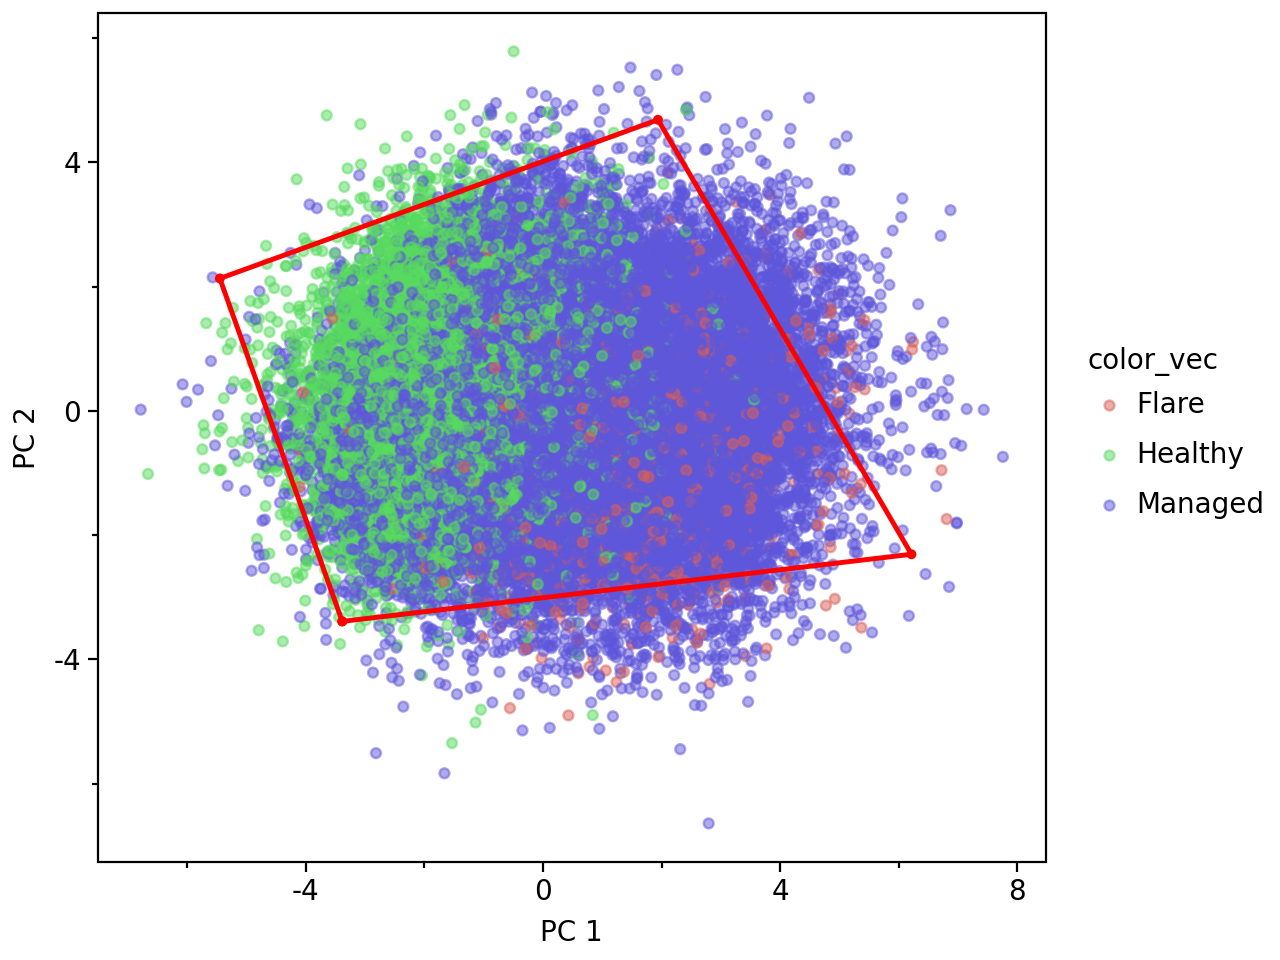

In [88]:
plot_2D(X=adata_ncM, color_vec=col)

For a 3D representation, we can plot the data along with the archetypes in a 3D space. You may choose to subset the data if necessary:

In [128]:
# fig_3D_simplex = plot_3D(adata_ncM.obsm["X_pca_reduced"][:2000],Z, color_vec=col[:2000], opacity=0.5)
# fig_3D_simplex = plot_3D(adata_ncM.obsm["X_pca_reduced"][adata_ncM.obs["Status"] == "Healthy"],Z)
AA_3D = plot_3D(X=adata_ncM, color_vec=col)
AA_3D.show()

## Identify representatives

To assign tasks to the archetypes, we need to identify cells that are representative of each archetype. To do this, we calculate a weighted pseudobulk for each archetype.

First, we calculate the weights for each cell based on its distance from the archetypes. The length scale of the RBF kernel is automatically set as half the median distance from the data centroid to the archetypes. However, this can also be manually adjusted if needed:

In [90]:
calculate_weights(X=adata_ncM, mode="automatic")

Applied length scale is 3.1435859432362507.


We can visualize the cell weights for each archetype to assess their distribution:

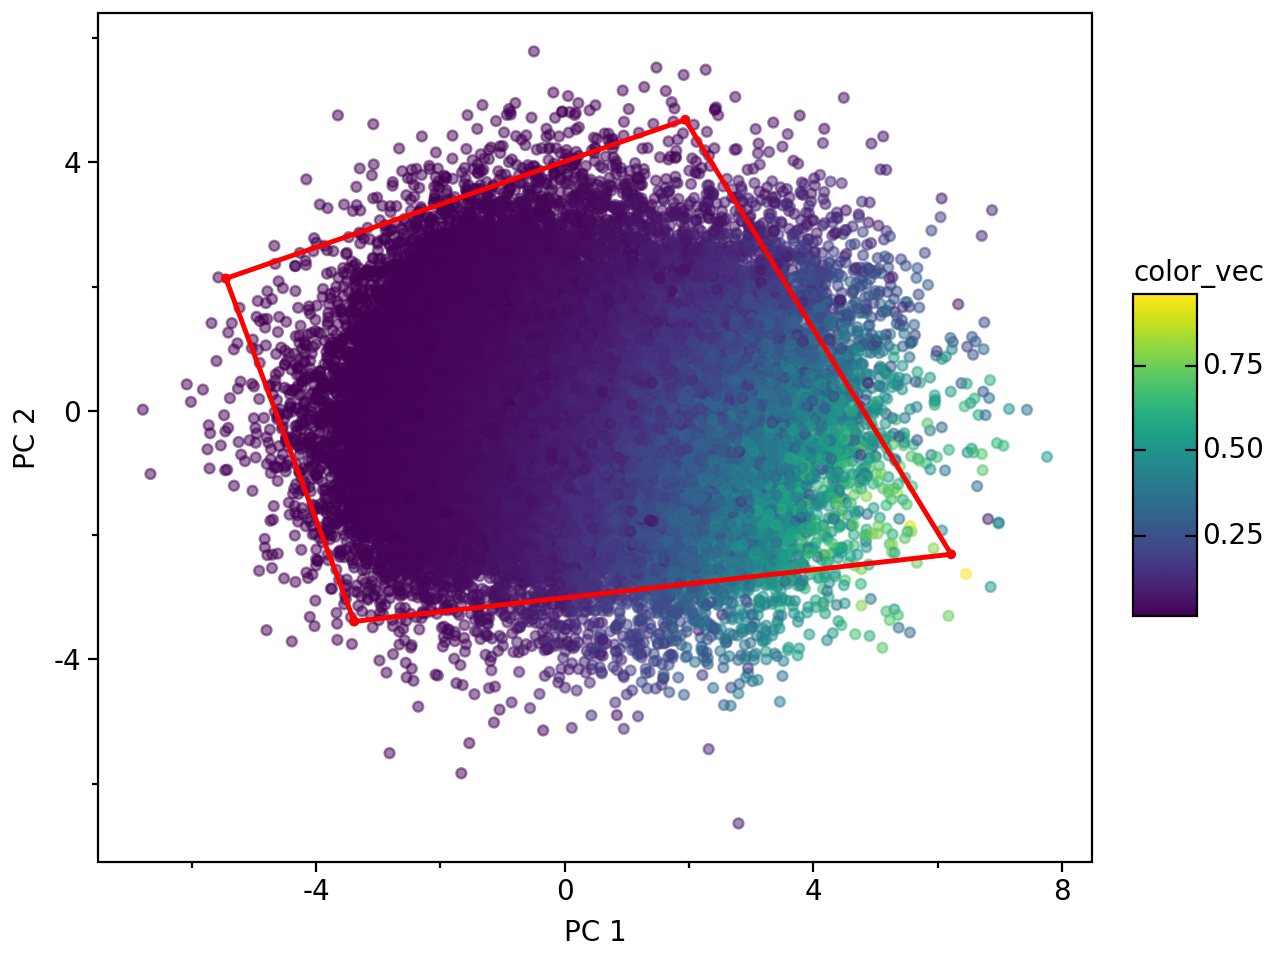

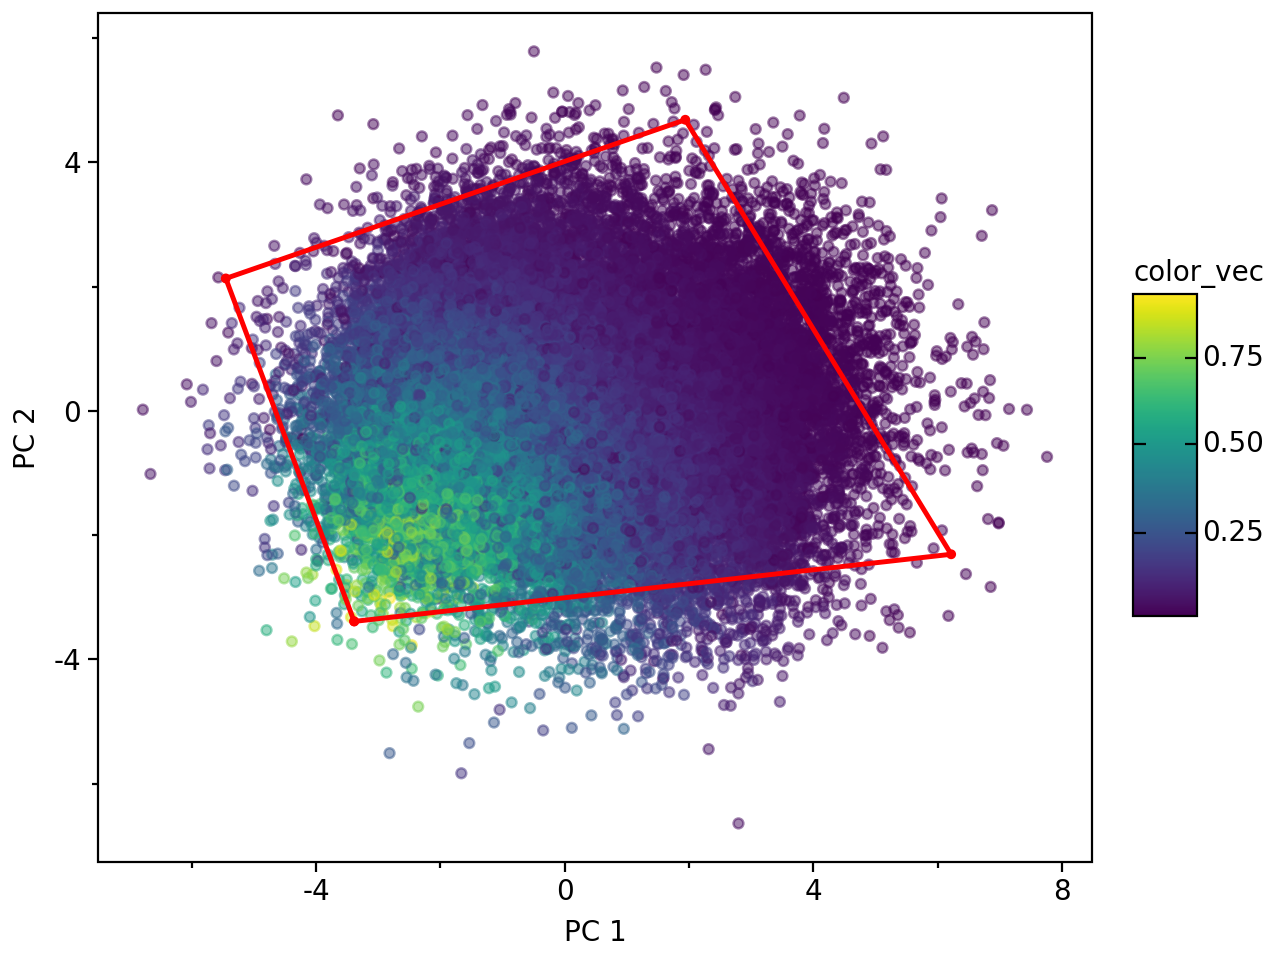

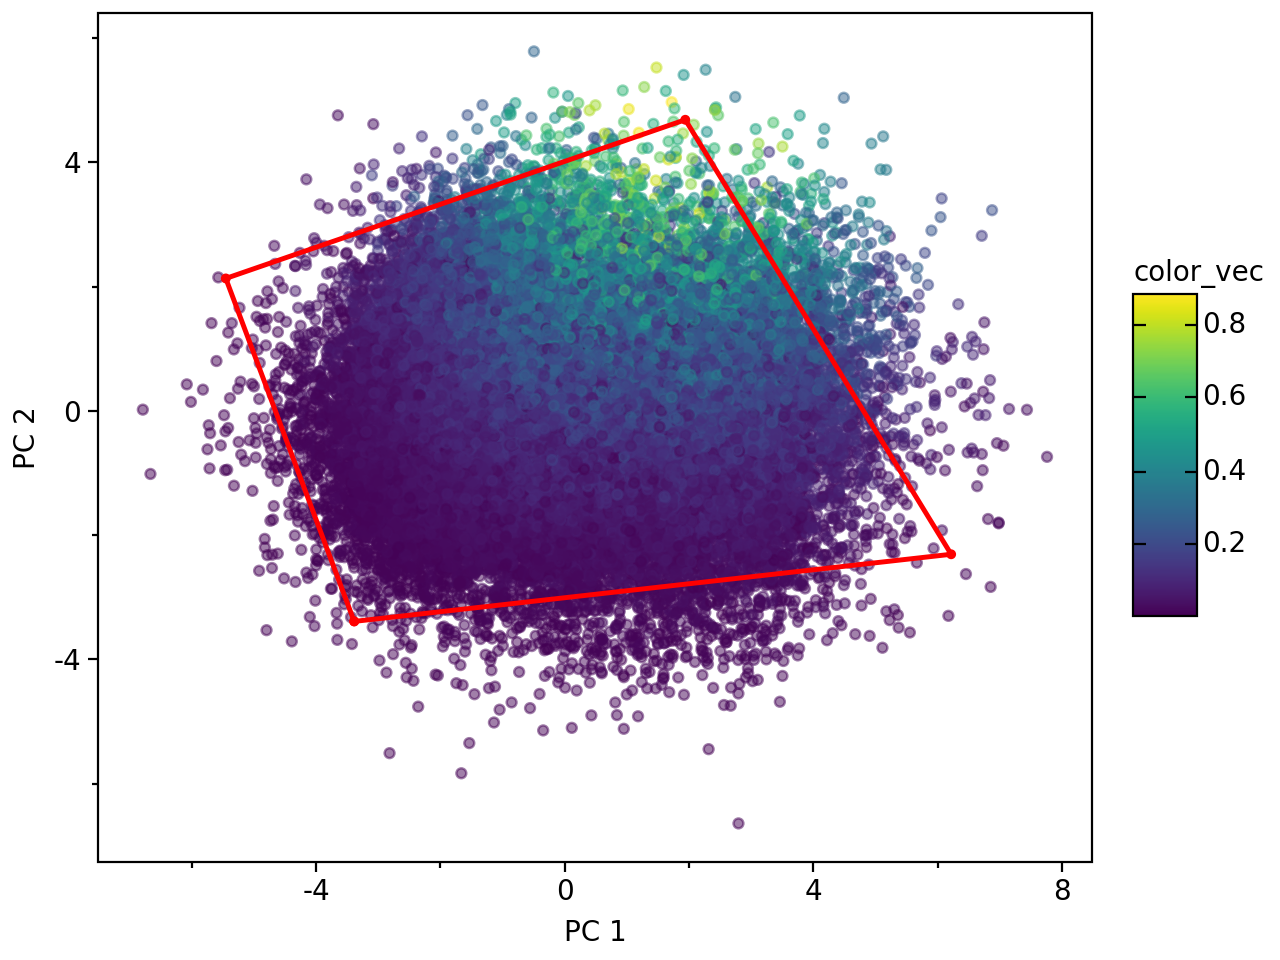

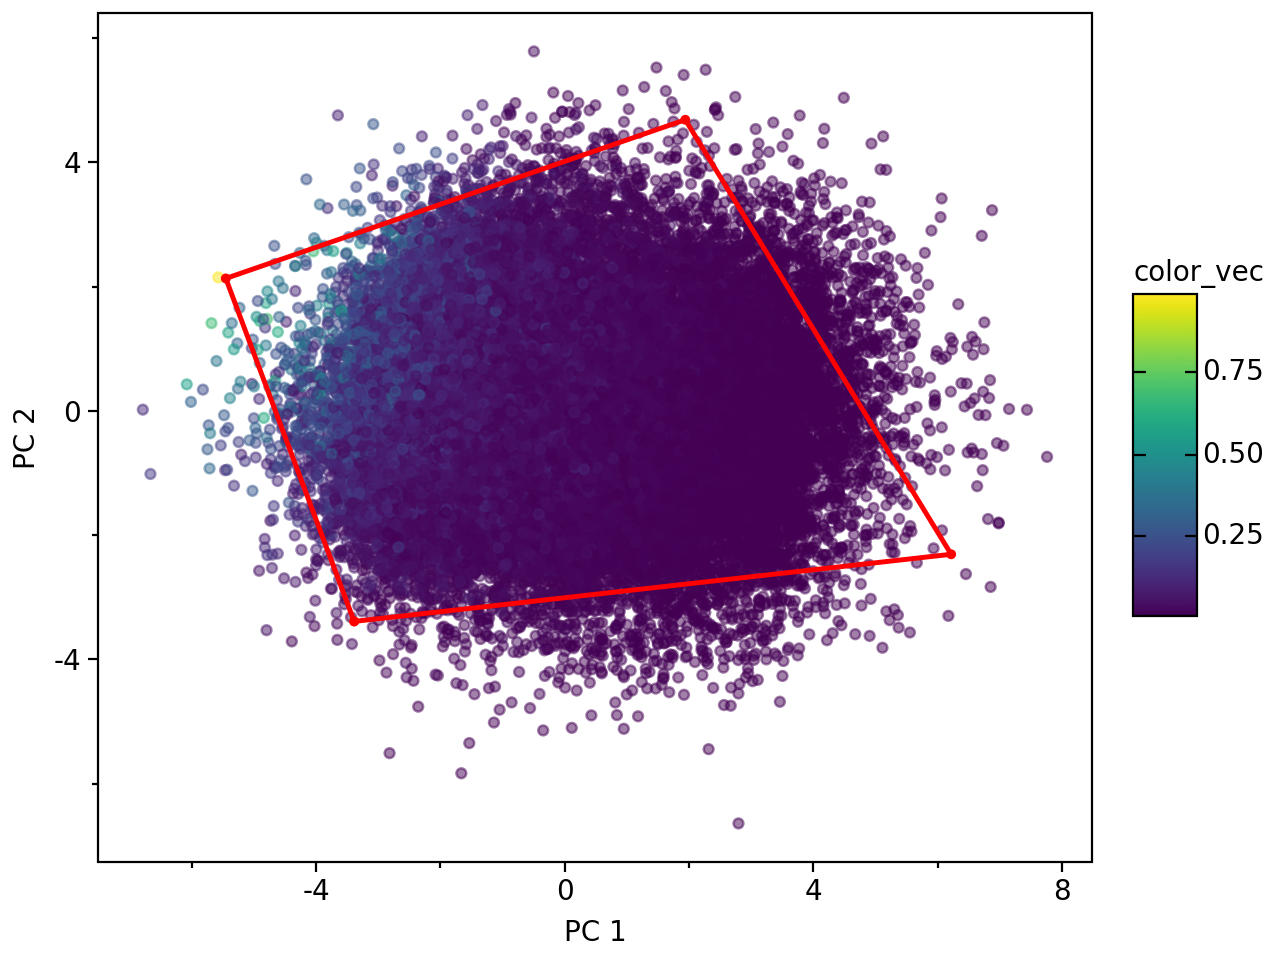

In [91]:
for i in range(0,4):
    plt = plot_2D(adata_ncM, color_vec=adata_ncM.obsm["cell_weights"].T[i])
    plt.show()
# For 3D plot simply replace the function name

Next, we compute a pseudobulk using the z-scaled gene expression data to observe differences in gene expression across the archetypes:

In [92]:
pseudobulk = weighted_expr(adata=adata_ncM, layer="z_scaled")

In [93]:
print(pseudobulk.head())

   RP11-34P13.7  AL627309.1  AP006222.2  RP4-669L17.10  RP11-206L10.3  \
0     -0.021163   -0.013951    0.007054      -0.022265      -0.018431   
1     -0.020372   -0.010423    0.002435      -0.021206      -0.016012   
2     -0.019150   -0.009650    0.003504      -0.021370      -0.007765   
3     -0.021506    0.010647   -0.015503      -0.015105       0.055023   

   RP11-206L10.5  RP11-206L10.2  RP11-206L10.9    FAM87B  LINC00115  ...  \
0      -0.008878      -0.025742      -0.023893 -0.015173  -0.011302  ...   
1      -0.009859      -0.012453      -0.022726 -0.016291  -0.013934  ...   
2      -0.009304      -0.003120      -0.014652 -0.015042  -0.009098  ...   
3      -0.010145       0.035476      -0.004053 -0.014139  -0.010706  ...   

     MT-ND6    MT-CYB  AC145212.1  AC011043.1  AL592183.1  AC011841.1  \
0 -0.067295 -0.542595   -0.015089   -0.011537   -0.073597   -0.014522   
1 -0.000460  0.196424   -0.017212   -0.013239    0.032041   -0.013318   
2 -0.020005 -0.042310   -0.001851 

## Functional Enrichment

For functional enrichment, we use Decoupler with Gene Ontology (GO) biological processes. While other collections can be used, it’s recommended to choose those with less broad categories to avoid non-significant results.

We begin by loading the MSigDB resource and filtering for the GO biological processes collection:

In [94]:
msigdb_raw = dc.get_resource('MSigDB')
msigdb = msigdb_raw[msigdb_raw['collection']=='go_biological_process']
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

Next, we run ULM on the pseudobulk data using the filtered MSigDB resource. The results are saved in acts_ulm_est and acts_ulm_est_p:

In [95]:
acts_ulm_est, acts_ulm_est_p = dc.run_ulm(mat = pseudobulk,
                                net = msigdb,
                                weight = None,
                                source='geneset',
                                target='genesymbol')

acts_ulm_est

GOBP_EMBRYO_DEVELOPMENT  GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS  \
0                -2.581937                                           1.191153   
1                 1.155315                                          -0.969234   
2                 1.434863                                           9.119134   
3                 6.347663                                          12.511641   

   GOBP_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION  \
0                                          -1.368918    
1                                          -2.947782    
2                                           1.235620    
3                                           2.886573    

   GOBP_EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG_HATCHING  \
0                                          -1.608426         
1                                           0.579917         
2                                           1.417444         
3                                           5.503737         

   GOBP_IN_UTERO_EMBRYONIC_DEVELOPMENT  \
0                            -0.645137   
1                             0.311682   
2                             2.595980   
3                             4.593159   

   GOBP_MULTI_MULTICELLULAR_ORGANISM_PROCESS  \
0                                   0.210770   
1                                  -1.874413   
2                                   3.040843   
3                                   0.016858   

   GOBP_NEGATIVE_REGULATION_OF_BIOSYNTHETIC_PROCESS  \
0                                          0.673811   
1                                         -1.344320   
2                                          7.021953   
3                                         10.052776   

   GOBP_EPITHELIUM_DEVELOPMENT  \
0                    -1.025022   
1                    -1.555729   
2                     2.614078   
3                     4.268152   

   GOBP_POSITIVE_REGULATION_OF_TRANSCRIPTION_BY_RNA_POLYMERASE_II  \
0                                           0.123125                
1                                          -2.941383                
2                                           6.670335                
3                                          10.684835                

   GOBP_EPIDERMIS_DEVELOPMENT  ...  \
0                   -1.320804  ...   
1                   -1.166590  ...   
2                    2.504956  ...   
3                    2.478878  ...   

   GOBP_RIBOSOME_ASSOCIATED_UBIQUITIN_DEPENDENT_PROTEIN_CATABOLIC_PROCESS  \
0                                           0.456090                        
1                                           0.599427                        
2                                           0.738910                        
3                                           1.170653                        

   GOBP_OUTER_DYNEIN_ARM_ASSEMBLY  \
0                       -0.386300   
1                       -0.488955   
2                       -0.580676   
3                       -0.113973   

   GOBP_NEGATIVE_REGULATION_OF_PROTEIN_LOCALIZATION_TO_MICROTUBULE  \
0                                          -0.574144                 
1                                          -0.394729                 
2                                          -0.149659                 
3                                           0.923240                 

   GOBP_MITOCHONDRIAL_RIBOSOME_ASSEMBLY  \
0                              0.372681   
1                              0.817460   
2                              0.840890   
3                             -0.070379   

   GOBP_DETERMINATION_OF_DIGESTIVE_TRACT_LEFT_RIGHT_ASYMMETRY  \
0                                          -0.452890            
1                                          -0.745201            
2                                          -0.490493            
3                                           0.157272            

   GOBP_EPITHELIAL_CILIUM_MOVEMENT_INVOLVED_IN_DETERMINATION_OF_LEFT_RIGHT_ASYMMETRY  \
0          

To identify the top enriched processes for each archetype, we extract the top n processes and order them in descending order:

In [96]:
top_processes = extract_top_processes(est=acts_ulm_est, 
                                      pval=acts_ulm_est_p, 
                                      order="desc", 
                                      n=20, 
                                      p_threshold=0.05)

We can access them using the keys in the form of "archetype_X":

In [104]:
top_processes["archetype_0"]

Process      Score
0   GOBP_NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLI...  29.261604
1           GOBP_NEGATIVE_REGULATION_OF_VIRAL_PROCESS  28.129650
2                   GOBP_DEFENSE_RESPONSE_TO_SYMBIONT  26.728619
3             GOBP_DEFENSE_RESPONSE_TO_OTHER_ORGANISM  25.388407
4                         GOBP_INNATE_IMMUNE_RESPONSE  25.088573
5                              GOBP_RESPONSE_TO_VIRUS  24.479570
6   GOBP_BIOLOGICAL_PROCESS_INVOLVED_IN_INTERSPECI...  24.159769
7                               GOBP_DEFENSE_RESPONSE  23.438442
8                    GOBP_REGULATION_OF_VIRAL_PROCESS  23.168356
9         GOBP_REGULATION_OF_VIRAL_GENOME_REPLICATION  22.915892
10                               GOBP_IMMUNE_RESPONSE  22.811972
11                 GOBP_RESPONSE_TO_TYPE_I_INTERFERON  21.213903
12                   GOBP_RESPONSE_TO_INTERFERON_BETA  20.749132
13                      GOBP_VIRAL_GENOME_REPLICATION  19.371235
14         GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY  18.510464
15                              GOBP_VIRAL_LIFE_CYCLE  18.440834
16                                 GOBP_VIRAL_PROCESS  17.057676
17       GOBP_NEGATIVE_REGULATION_OF_VIRAL_LIFE_CYCLE  16.944868
18     GOBP_REGULATION_OF_RESPONSE_TO_BIOTIC_STIMULUS  16.336056
19                 GOBP_REGULATION_OF_IMMUNE_RESPONSE  16.263189

We observe that e.g. archetype 0 is associated with immun response to viruses and responding to interferon. On the other hand

In [105]:
top_processes["archetype_3"]

Process      Score
0                        GOBP_CYTOPLASMIC_TRANSLATION  13.837277
1   GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS  12.511641
2   GOBP_POSITIVE_REGULATION_OF_MACROMOLECULE_BIOS...  11.630281
3   GOBP_POSITIVE_REGULATION_OF_TRANSCRIPTION_BY_R...  10.684835
4                         GOBP_CHROMATIN_ORGANIZATION  10.434361
5   GOBP_NEGATIVE_REGULATION_OF_NUCLEOBASE_CONTAIN...  10.232633
6    GOBP_NEGATIVE_REGULATION_OF_BIOSYNTHETIC_PROCESS  10.052776
7   GOBP_NEGATIVE_REGULATION_OF_RNA_BIOSYNTHETIC_P...   9.385510
8   GOBP_NEGATIVE_REGULATION_OF_TRANSCRIPTION_BY_R...   9.084257
9                           GOBP_HISTONE_MODIFICATION   8.617611
10                               GOBP_PHOSPHORYLATION   8.486627
11                          GOBP_CHROMATIN_REMODELING   8.254764
12                        GOBP_MRNA_METABOLIC_PROCESS   8.193174
13          GOBP_REGULATION_OF_MRNA_METABOLIC_PROCESS   7.967426
14   GOBP_CELLULAR_MACROMOLECULE_BIOSYNTHETIC_PROCESS   7.960967
15                  GOBP_PEPTIDE_BIOSYNTHETIC_PROCESS   7.959262
16                    GOBP_AMIDE_BIOSYNTHETIC_PROCESS   7.767856
17                                GOBP_RNA_PROCESSING   7.489221
18                    GOBP_REGULATION_OF_RNA_SPLICING   7.399476
19                     GOBP_PEPTIDE_METABOLIC_PROCESS   7.358696

On the other hand, archetype 3 seems to represent the task of upkeeping homeostasis and normal cellular function in the cells.

To identify processes specific to a particular archetype, meaning they are in the top enriched processes of one archetype and below a specified threshold (drop_threshold) for all other archetypes, we apply the following function:

In [106]:
specific_processes= extract_top_specific_processes(est=acts_ulm_est,
                                                   pval=acts_ulm_est_p, 
                                                   drop_threshold = 2,
                                                   n=20,
                                                   p_threshold=0.05)

specific_processes["archetype_0"]

GOBP_NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLICATION  \
0                                          29.261604      
1                                         -17.601200      
2                                           0.100709      
3                                         -15.206884      

   GOBP_REGULATION_OF_VIRAL_GENOME_REPLICATION  \
0                                    22.915892   
1                                   -14.544783   
2                                     1.821618   
3                                   -10.115027   

   GOBP_RESPONSE_TO_TYPE_I_INTERFERON  GOBP_RESPONSE_TO_INTERFERON_BETA  \
0                           21.213903                         20.749132   
1                          -12.140556                        -12.144448   
2                            0.324482                          0.692818   
3                           -9.469765                        -12.172740   

   GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY  
0                                   18.510464  
1                                  -10.777160  
2                                    1.376381  
3                                   -8.411726

## Enrichment Metadata

We can also investigate the enrichment of metadata stored in obs. For example, to check the enrichment by the "Status" column:

In [99]:
meta_enrichment(adata=adata_ncM, meta="Status")

Flare   Healthy   Managed
0  0.546492  0.081262  0.372246
1  0.249188  0.463868  0.286944
2  0.306199  0.323331  0.370471
3  0.143752  0.590276  0.265972

We find ncM with the "Flare" status enriched at archetype 0 and not associated with archetype 3. We can observe such distribution in the PCA space when plotting only the ncM with "Flare" status: 

In [130]:
flare_3D = plot_3D(adata_ncM.obsm["X_pca_reduced"][adata_ncM.obs["Status"] == "Flare"], Z)
flare_3D.show()

## Ideas for more functions:


Maybe the coverage stuff?

In [101]:
# archetype = "3"

# filtered_columns = acts_ulm_est_p.loc[archetype] < 0.05

# highest_processes = acts_ulm_est.loc[archetype, filtered_columns.index].nlargest(50).index

# subset = acts_ulm_est.loc[:, highest_processes]

# filtered_processes = highest_processes[(subset.drop(index=archetype) < 5).all(axis=0)]
# # coverage
# msigdb['in_adata'] = msigdb["genesymbol"].isin(adata_ncM.var.index.to_list())
# msigdb["geneset"] = msigdb["geneset"].astype(str)

# coverage_result = msigdb.groupby("geneset").agg(
#     coverage=pd.NamedAgg(column="in_adata", aggfunc="mean")
# ).reset_index()

# coverage_dict = dict(zip(coverage_result["geneset"], coverage_result["coverage"]))

# # Add coverage as a row in the resulting DataFrame
# result_with_coverage = acts_ulm_est.loc[:, filtered_processes].copy()
# result_with_coverage.loc["coverage"] = [coverage_dict.get(process, 0) for process in filtered_processes]

# result_with_coverage

This can be run to see how different numbers of archetypes influence the mean archetype variance

In [102]:
# res = []
# for i in range(2,6):
#     bootstrap_df = bootstrap_AA(X, n_bootstrap=i, n_archetypes=n_archetypes, plot=False)
#     for value in bootstrap_df['mean_variance']:
#         res.append({'iteration': i, 'mean_variance': value})
# results_df = pd.DataFrame(res)
# results_df_2 = results_df.drop_duplicates(keep='first')
# p = (
#         pn.ggplot(results_df_2, pn.aes(x="iteration", y="mean_variance"))
#         + pn.geom_point(color="blue")
#         + pn.geom_line(color="blue")
#         + pn.labs(x="Number of Archetypes", y="Mean Variance in Archetype Position")
#     )
# p

t-ratio